In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Attention

We first try to create an attention block from scratch

In [ ]:
class attentionHead(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.1):
        super(attentionHead, self).__init__()
        # Note that here a 1d mlp is used for each of the key, query and value layers cause I laze
        # However, this need not be the case (think attention in the context of computer vision)
        self.key = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Dropout(dropout),
            nn.LayerNorm(out_dim)
            ) 
        self.query = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Dropout(dropout),
            nn.LayerNorm(out_dim)
            ) 
        self.value = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.Dropout(dropout),
            nn.LayerNorm(out_dim)
            )
    
    def forward(self, input_seq):
        keys = self.key(input_seq)
        queries = self.query(input_seq)
        values = self.value(input_seq)
        
        attn_weights = torch.bmm(queries, keys.transpose(-1, -2)) / (keys.size(-1)**0.5) # The division by dimensionality of the keys is optional
        attn_weights = torch.softmax(attn_weights, dim=-1)
        output = torch.bmm(attn_weights, values)

        return output

In pytorch, it is quite abit simpler, since u now know how each parameter affects the architecture

In [ ]:
in_dim = 4
nheads = 2
dropout = 0.1

attn_head = nn.MultiheadAttention(embed_dim=in_dim, num_heads=nheads, dropout=dropout)

## Padding and masks

Since attention is often used for sequential data (although it doesn't have to be), most implementations allow for masks  

Masks are additional instructions for the attention block. Generally, they are used to tell the attention block which inputs or which queries to ignore

In [ ]:
test_in = torch.rand(20, 1, 4)
test_in

tensor([[[0.3105, 0.2429, 0.2463, 0.9701]],

        [[0.8205, 0.3993, 0.0316, 0.6546]],

        [[0.3330, 0.2936, 0.0409, 0.1465]],

        [[0.8662, 0.2983, 0.0686, 0.5670]],

        [[0.6207, 0.0541, 0.5708, 0.1329]],

        [[0.9946, 0.6998, 0.1297, 0.6453]],

        [[0.3696, 0.2530, 0.6212, 0.2078]],

        [[0.7603, 0.2673, 0.5176, 0.6646]],

        [[0.2588, 0.2168, 0.6690, 0.3860]],

        [[0.4120, 0.2928, 0.1823, 0.5635]],

        [[0.7842, 0.2465, 0.7104, 0.3370]],

        [[0.7649, 0.4409, 0.6664, 0.7832]],

        [[0.5058, 0.4272, 0.5545, 0.0989]],

        [[0.3364, 0.8138, 0.6794, 0.4634]],

        [[0.3426, 0.7699, 0.7972, 0.4467]],

        [[0.5289, 0.2924, 0.7417, 0.1581]],

        [[0.0802, 0.8243, 0.8750, 0.6600]],

        [[0.6331, 0.2654, 0.9219, 0.4973]],

        [[0.8462, 0.6075, 0.3600, 0.3159]],

        [[0.1261, 0.0888, 0.8975, 0.1636]]])

Let's look at the simpler type of mask, **Padding Masks**  

Padding masks are used to tell which elements in the input sequence to ignore

In [ ]:
pad_mask = torch.cat([torch.ones(1, 2), torch.zeros(1, 18)], dim=1) == 1
attentions = attn_head(test_in, test_in, test_in, key_padding_mask=pad_mask)[1]
attentions

tensor([[[0.0000, 0.0000, 0.0605, 0.0312, 0.0631, 0.0647, 0.0605, 0.0651,
          0.0303, 0.0626, 0.0639, 0.0645, 0.0601, 0.0582, 0.0583, 0.0611,
          0.0570, 0.0631, 0.0625, 0.0593],
         [0.0000, 0.0000, 0.0341, 0.0606, 0.0644, 0.0588, 0.0634, 0.0606,
          0.0627, 0.0609, 0.0327, 0.0596, 0.0632, 0.0600, 0.0603, 0.0315,
          0.0593, 0.0619, 0.0316, 0.0303],
         [0.0000, 0.0000, 0.0622, 0.0287, 0.0628, 0.0588, 0.0631, 0.0603,
          0.0627, 0.0607, 0.0315, 0.0600, 0.0322, 0.0618, 0.0315, 0.0631,
          0.0620, 0.0619, 0.0608, 0.0645],
         [0.0000, 0.0000, 0.0340, 0.0314, 0.0642, 0.0591, 0.0633, 0.0609,
          0.0627, 0.0613, 0.0625, 0.0598, 0.0630, 0.0600, 0.0602, 0.0633,
          0.0593, 0.0619, 0.0610, 0.0645],
         [0.0000, 0.0000, 0.0600, 0.0627, 0.0622, 0.0614, 0.0309, 0.0637,
          0.0622, 0.0298, 0.0309, 0.0637, 0.0602, 0.0600, 0.0604, 0.0614,
          0.0608, 0.0635, 0.0605, 0.0621],
         [0.0000, 0.0000, 0.0631, 0.0579, 0.0

Notice how the first 2 of each sequence here is always 0?  

This is because the mask we fed in tells the attention block to ignore the first 2 elements of the input sequence

Next let's look at something more complex, an **attention mask**  

It's job is similar to the padding mask. However, it tells the attention block what to ignore specifically for each element of the output sequence.  
In other words, it is a padding mask tailored for each element of the output sequence

In [ ]:
# attn_mask = torch.cat([torch.ones(10, 20), torch.zeros(10, 20)], dim=0) == 1
attn_mask = torch.ones(20, 20)
attn_mask = torch.triu(attn_mask) == 1
attentions = attn_head(test_in, test_in, test_in, attn_mask=attn_mask)[1]
attentions

tensor([[[   nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan,    nan,    nan,    nan,    nan,    nan,    nan,    nan,
             nan,    nan,    nan,    nan],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.5577, 0.5534, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.3622, 0.3654, 0.3836, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.2863, 0.1405, 0.1330, 0.2792, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.2116, 0.2107, 0.2340, 0.1142, 0.2

Zhao Jie explain using excel

# Transformers

Of course in practice, attention is often used in architectures similar to the [Transformer Architecture](https://arxiv.org/pdf/1706.03762.pdf)  
So let's take a close look at the Transformer block and see how it further refines the attention mechanism  
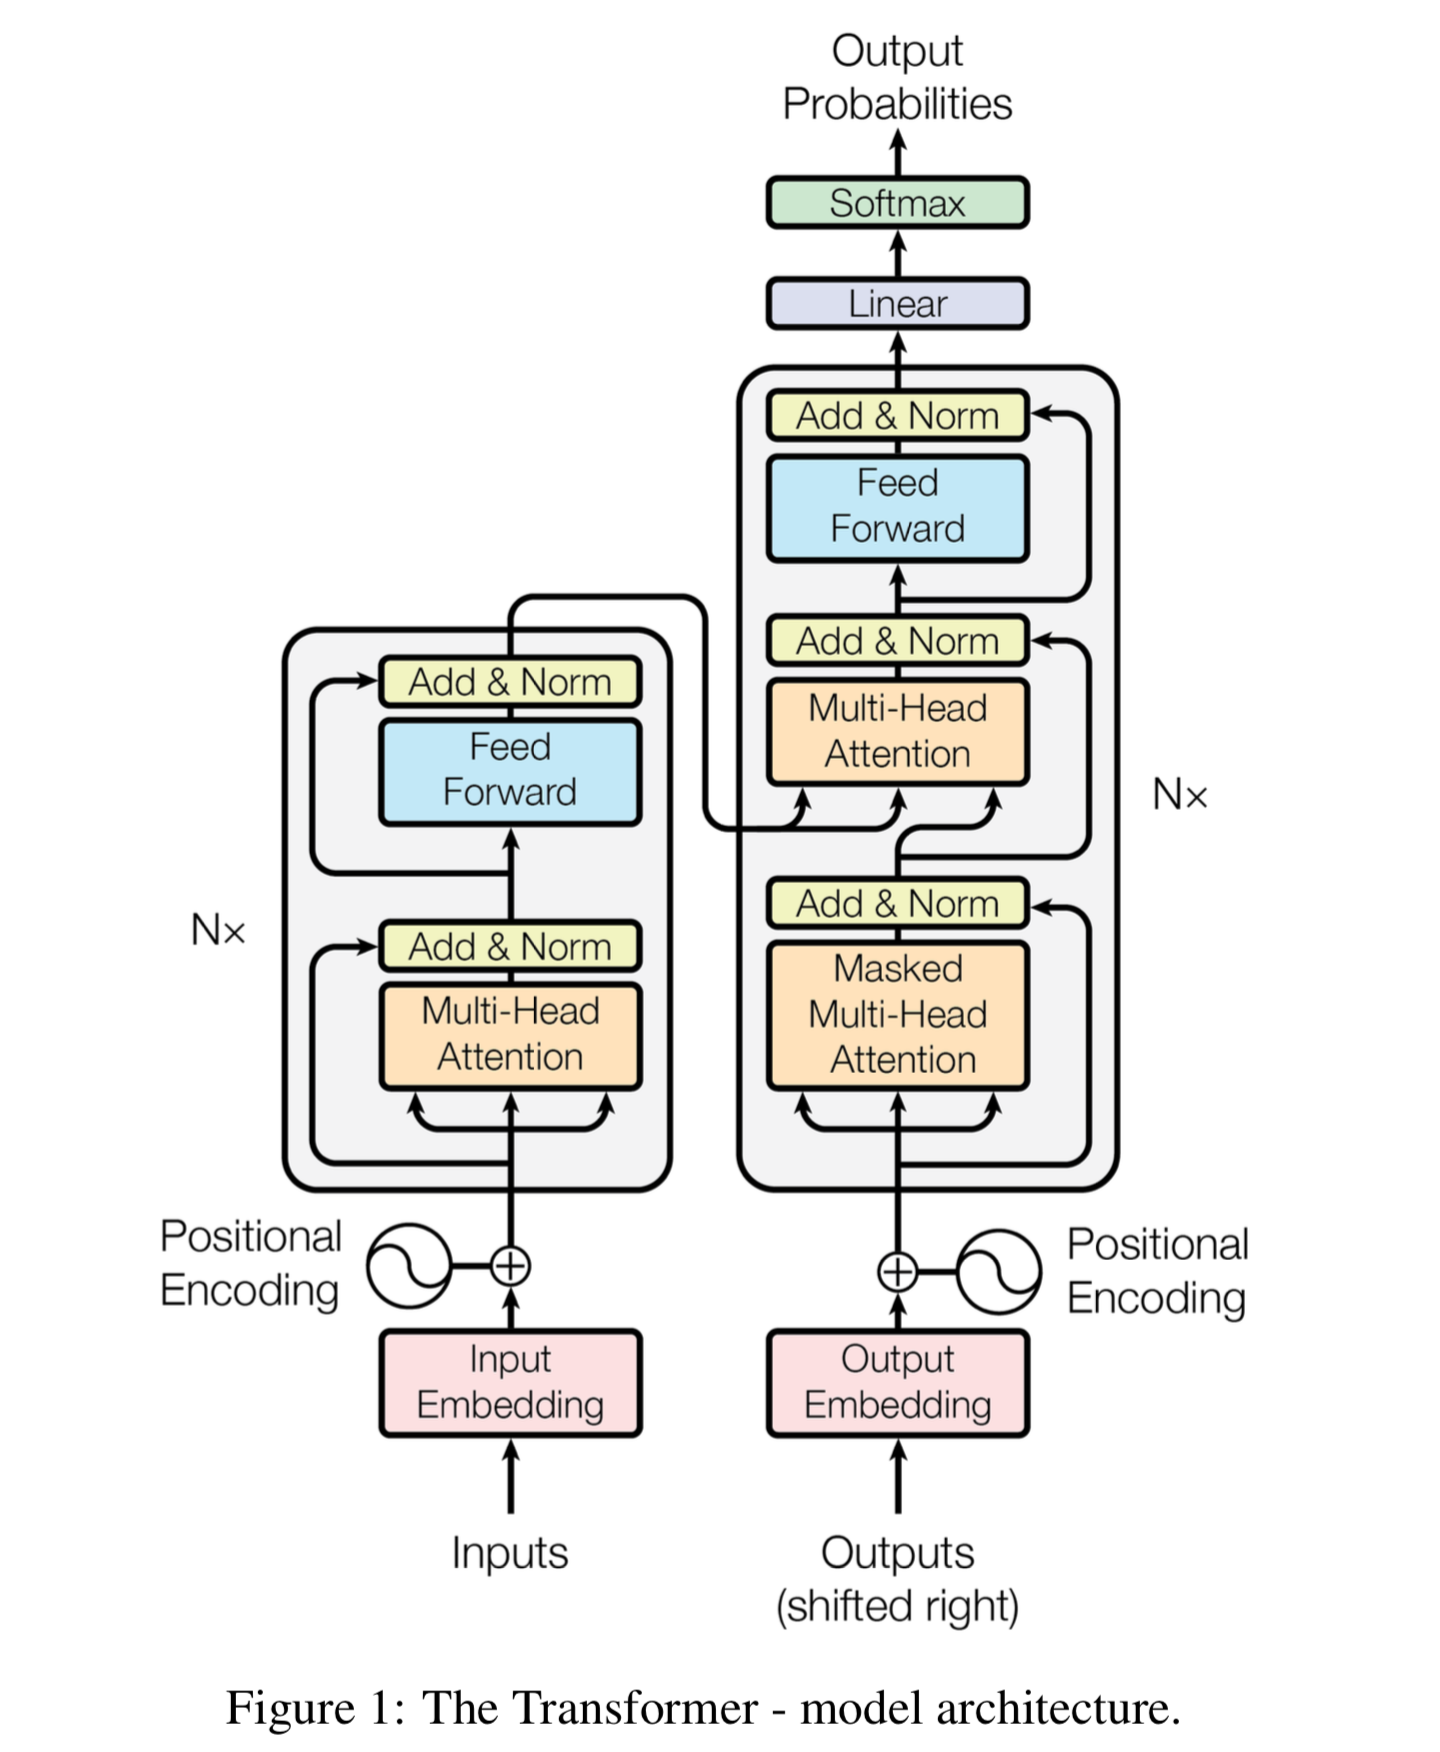

## Positional Encoding

Probably just as significant (but not as important) as the actual 2 blocks are the positional encoding layers. Interestingly, this layer is non-trainable, but rather just a "simple" mathematical function to encode the position of an input  

NOTE: The addition of positional encodings has stronger support intuitively than theoretically, since no one really bothers to investigate its effect thoroughly. Basically it brings potential benefits but does no harm

In [ ]:
class posEncoder(nn.Module):
    def __init__(self, dim, max_len):
        assert dim%2 == 0 # not really necessary, but just makes life easier
        
        self.max_len = max_len
        self.dim = dim
        self.pos_ = torch.arange(0, max_len, 1).float()
        freq = (torch.arange(0, dim/2, 2)*2)/dim
        freq = 1/(10000**freq)
        freq = freq.float()
        self.freq = torch.matmul(pos_.unsqueeze(1), freq.unsqueeze(0))

    def forward(self):
        encodings = torch.zeros(self.max_len, self.dim)
        encodings[:, 0::2] = torch.sin(self.pos_ * self.freq)
        encodings[:, 1::2] = torch.cos(self.pos_ * self.freq)

        return encodings

## Encoders

Immediately we can see that there are 2 distinct blocks.  

The shorter left block is the encoder block which we will try to implement  
NOTE: there are many implementation details we are leaving out at this point, but for now focus on understanding the fundamental form of a transformer's forward pass

In [ ]:
class encoder(nn.Module):
    def __init__(self, dim, dropout=0.1, nheads=1, ff_layers=1):
        assert ff_layers > 0
        assert nheads > 0

        super(encoder, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(nheads):
            head = attentionHead(dim, dim, dropout)
            self.heads.append(head)
        self.multihead_filter = nn.Linear(dim*nheads, dim)
        self.head_norm = nn.BatchNorm1d(dim)

        ff_layers = nn.ModuleList()
        for i in range(ff_layers):
            block = nn.Sequential(
                nn.Linear(dim, dim),
                nn.Dropout(dropout),
                nn.BatchNorm1d(dim)
            )
            ff_layers.append(block)
        self.ff_block = nn.Sequential(ff_layers)
        self.ff_norm = nn.BatchNorm1d(dim)

    def forward(self, input_embs, pos_encodings=None):
        if pos_encodings != None:
            input_embs += pos_encodings
        
        head_outs = None
        for head in self.heads:
            if head_outs is None:
                head_outs = head(input_embs)
            else:
                head_outs = torch.cat(input_embs, dim=-1)
        head_outs = self.multihead_filter(head_outs)
        head_outs += input_embs
        head_outs = self.head_norm(head_outs)

        x = self.ff_block(head_outs)
        x += head_outs
        x = self.ff_norm(x)

        return x

Of course, unless you require specific uses, (such as high dimensional attention), it is probably a better idea to use the encoder provided by pytorch

In [ ]:
enc = nn.TransformerEncoderLayer(d_model=4, nhead=2)

## Decoders

Similarly, decoders can be instantiated using torch  
(We won't be creating it from scratch since it's almost completely the same as the encoder block)

In [ ]:
dec = nn.TransformerDecoderLayer(d_model=4, nhead=2)

Don't worry too much about the right shifting and the masking mentioned in the diagram. These are just techniques used for the particular training objective in the paper.  

In general, such masking or hiding of input/output embeddings is known as masked language modelling and generally will be applied differently depending on context. For those interested, read the pre training sections of [BERT](https://arxiv.org/pdf/1810.04805.pdf) and [GPT](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf)

# NLP

Of course most of the time, you probably won't be creating or even training transformers from scratch.  
This is due to their need for insane amounts of data and time to train  

Instead let's look at one of the most popular libraries for pre-trained transformers, [Hugging Face - Transformers](https://huggingface.co/transformers/)

We first need to install it since it doesnt come with colab

In [ ]:
!pip install transformers

## Loading pretrained models

In [ ]:
from transformers import BertModel

In [ ]:
bert = BertModel.from_pretrained("bert-base-cased")

So now we have the model. We need some tools for pre processing  

Note that your tokeniser is possibly your single most important tool in preprocessing textual data  

When using hugging face, generally u need a tokenizer that is suited for your particular model. This is due to differences in the implementation for the attention mask (attention mask is usually used to identify special tokens like end of sentence, classifer, or seperator tokens)

In [ ]:
from transformers import BertTokenizer
tok = BertTokenizer.from_pretrained("bert-base-cased") # note that your tokenizer needs to be of the same configuration as your model

The job of the tokenizer is of course to convert text into numbers, allowing the model to handle them more easily

In [ ]:
tokens = tok.encode(text="Should've gone to NUS")
tokens

[101, 9743, 112, 1396, 2065, 1106, 151, 13329, 102]

Notice that there's more numbers than words?  
This is due to the tokenizer splitting up certain words to allow for better perrformance

In [ ]:
tok.convert_ids_to_tokens(tokens)

['[CLS]', 'Should', "'", 've', 'gone', 'to', 'N', '##US', '[SEP]']

Go to [Hugging Face](https://huggingface.co/) to see a pre-trained NLP model in action.  

[Notebook example for using Hugging face API](https://drive.google.com/file/d/181w-AI5-etzOKCUy1FxgCCn1obbs4ZsT/view?usp=sharing)